<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Applied-Modeling/blob/master/module2/assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

### Colab Setup

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Checking out files: 100% (26/26), done.
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 112kB 16.4MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 57.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 46.5MB/s 
     |████████████████████████████████| 614kB 27.2MB/s 
     |████████████████████████████████| 235kB 44.1MB/s 
     |████████████████████████████████| 307kB 48.9MB/s 
     |████████████████████████████████| 215kB 37.0MB/s 
     |████████████████████████████████| 51kB 20.2MB/s 
     |████████████████████████████████| 737kB 36.0MB

### Important Imports

In [0]:
# libraries and math functions
import pandas as pd
import numpy as np
import pandas_profiling
from scipy.io import arff # for loading .arff file
from scipy.stats import randint, uniform

# imports for pipeline and regression/classification
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from ipywidgets import interact, fixed
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Importing dataset

Dataset has largely been cleaned previously 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')
print(df.shape)
df.head()

(292, 22)


,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,0,6.0,m,NaN,no,no,Jordan,yes,5,4-11 years,NaN,NO
3,4,0,1,0,0,1,1,0,0,0,1,5.0,f,NaN,yes,no,Jordan,no,4,4-11 years,NaN,NO
4,5,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


### Data Wrangling

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')

def data_wrangle(df):
  ''' cleaning the data with one function'''

  # null values
  df = df.fillna(value='unspecified')

  # Dropping columns with single value or counfounding values
  df = df.drop(['age_desc', 'result'], axis=1)

  # Dropping id column to prevent obfuscation of data
  df = df.drop('id', axis=1)

  # Cleaning column names
  df = df.rename(columns={'jundice':'born_jaundice', 
                          'austim':'family_pdd', 
                          'contry_of_res':'country', 
                          'used_app_before':'prior_screening'})
  
  # Changing the country column values to 'other' if there are less
  # than 5 instances in the df
  frequencies = df['country'].value_counts()
  condition = frequencies <= 5
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')

  df['country'] = df['country'].replace(mask_dict)

  # renaming values for clarity
  df['relation'] = df['relation'].replace(
      {'self':'Self', 
       'Health care professional':'Healthcare Professional', 
       'unspecified':'Unspecified'})
  
  df['ethnicity'] = df['ethnicity'].replace({'Pasifika':'Pacifica', 
                                           'Others':'unspecified'})

  return df

In [0]:
df = data_wrangle(df)

### Regression and Analysis

In [6]:
# Setting target and features
target = 'Class/ASD'

# Dropping 'result' and 'age' as they seem to be confounding and not helpful
features = df.columns.drop(target)

X = df[features]
y = df[target]

# Train / Test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Train / Val split 
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, 
    stratify=y_trainval, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((174, 18), (174,), (59, 18), (59,), (59, 18), (59,))

In [7]:
features

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'born_jaundice', 'family_pdd', 'country',
       'prior_screening', 'relation'],
      dtype='object')

#### Majority Class Accuracy

In [0]:
pd.options.display.float_format = None

In [9]:
y_train.value_counts(normalize=True)

NO     0.517241
YES    0.482759
Name: Class/ASD, dtype: float64

In [10]:
# Accuracy score using the majority class
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.5084745762711864

#### Random Forest Classifier with Ordinal Encoding

In [11]:
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.8983050847457628 
Test Accuracy: 0.864406779661017


### Feature Importances

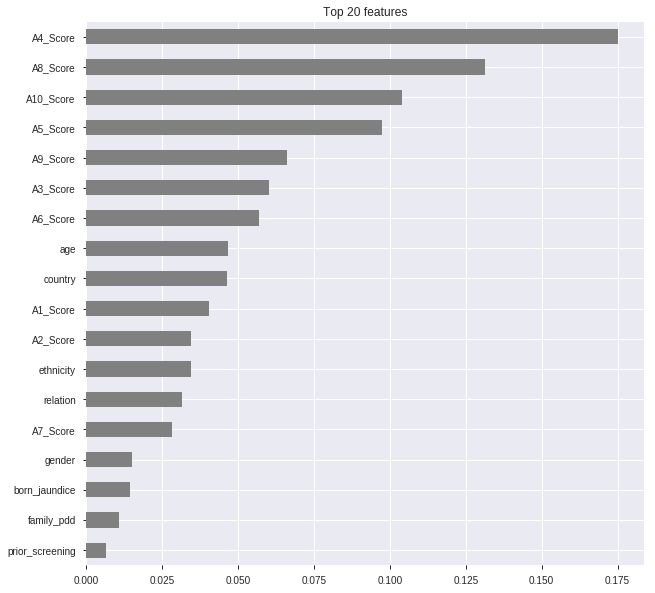

In [14]:
# Get feature importances
rf = random_forest.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Permutation Importances

In [15]:
score_with = random_forest.score(X_val, y_val)
X_val_permuted = X_val.copy()

# Looping through all features to test importance
for feature in X_train.columns:
  X_val_permuted[feature] = np.random.permutation(X_val[feature])

  score_permuted = random_forest.score(X_val_permuted, y_val)
  perm_imp = score_with - score_permuted

  print (f'Validation Accuracy with {feature}: {score_with}')
  print (f'Validation Accuracy with {feature} permuted: {score_permuted}')
  print (f'Permutation Importance: {score_with - score_permuted}')
  print('------------------------------------------------------\n')

Validation Accuracy with A1_Score: 0.8983050847457628
Validation Accuracy with A1_Score permuted: 0.847457627118644
Permutation Importance: 0.05084745762711873
------------------------------------------------------

Validation Accuracy with A2_Score: 0.8983050847457628
Validation Accuracy with A2_Score permuted: 0.7966101694915254
Permutation Importance: 0.10169491525423735
------------------------------------------------------

Validation Accuracy with A3_Score: 0.8983050847457628
Validation Accuracy with A3_Score permuted: 0.7796610169491526
Permutation Importance: 0.11864406779661019
------------------------------------------------------

Validation Accuracy with A4_Score: 0.8983050847457628
Validation Accuracy with A4_Score permuted: 0.6779661016949152
Permutation Importance: 0.22033898305084754
------------------------------------------------------

Validation Accuracy with A5_Score: 0.8983050847457628
Validation Accuracy with A5_Score permuted: 0.6440677966101694
Permutation Impo

#### Permutation with eli5 permutation importance

In [25]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1102 ± 0.0508,A4_Score
0.0508 ± 0.0000,A1_Score
0.0508 ± 0.0339,A10_Score
0.0424 ± 0.0169,A9_Score
0.0339 ± 0.0000,A2_Score
0.0254 ± 0.0169,age
0.0254 ± 0.0169,A7_Score
0.0169 ± 0.0000,gender
0.0169 ± 0.0000,country
0.0169 ± 0.0339,A3_Score


### XGBoost

In [24]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0847 ± 0.0000,A4_Score
0.0593 ± 0.0508,A9_Score
0.0508 ± 0.0000,A10_Score
0.0339 ± 0.0339,A2_Score
0.0085 ± 0.0169,A1_Score
0 ± 0.0000,ethnicity
0 ± 0.0000,gender
0 ± 0.0000,prior_screening
0 ± 0.0000,A7_Score
0 ± 0.0000,family_pdd


Interestingly between the Random Forest Classifier and XGBoost, it appears that A1, 2, 4, 9, and 10 are the most important features, where features like born with jaundice, family_pdd (history), and prior screening are all less likely to improve the prediction. 